<a href="https://colab.research.google.com/github/minshyee/RecoSyS/blob/main/Collaborative_Filtering_RecoSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# set enviroment
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Collaborative Filtering RecoSys

전제 : 어떤 아이템에 대해 비슷한 취향을 가진 사람들은 다른 아이템 또한 비슷한 취향을 가질것이다.

가정 : 추천 대상과 유사한(취향이 비슷한) 집단이 있을 것이다.
  - 다른 대상과 유사성을 계산
  - 유사성이 높은 대상들을 취향이 비슷한 집단으로 판단


### 유사도지표
- 상관계수 : 이 지표 하나만을 가지고 판단할 수 없음

$$
-1 \le r = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{{\sum(x_i - \bar{x})^2\times\sum(y_i - \bar{y})^2}}} \le 1
$$
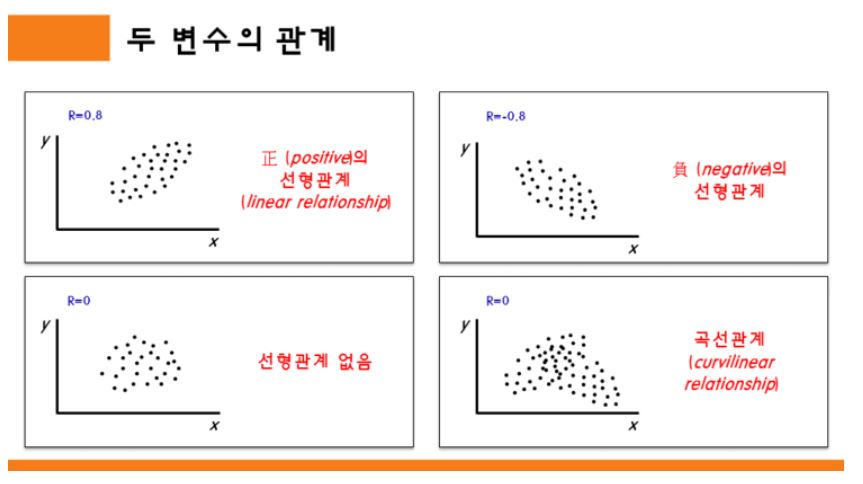
- 코사인 유사도 : 협업 필터링 알고리즘에서 널리 쓰임(주로 연속값)
  - 각 아이템 = 하나의 차원, 사용자의 평가값 = 좌표값이라고 설정
  - 두 사용자의 평가값이 유사하다면,
  𝛳는 작아지고, ${cos𝛳}$의 값은 커진다

  
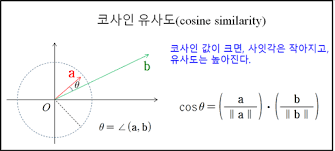



$$
-1 \le similarity = cos θ =  \frac{A \bullet B}{\lVert A \rVert \lVert B \rVert} 
= \frac{\sum{A_iB_i}}{\sqrt{\sum{A_i^2}}\sqrt{\sum{B_i^2}}}\ \le 1
$$
- 데이터가 연속값이 아니라 이진값이라면, 타니모토 계수(tanimoto coefficient) 사용을 권장한다.
- 자카드 계수의 변형 형태 
  - 자타드 계수는 합집합 분의 교집합

$$
Tanimoto\ coef = \frac{N_{a\cap b}}{N_a + N_b - N_{a\cap b}}
$$
${N_a}$는 a가 선호하는 아이템의 개수
```python3
def tanimoto(a,b):
  c=[v for v in a if v in b]
  return float(len(c))/len(a)+len(b)-len(c)
```



### 기본 CF 알고리즘
<center>

모든 사용자 간 평가의 유사도 계산 </br>

🔽 </br>

추천 대상과 다른 사용자간 유사도 추출 </br>

🔽 </br>

추천 대상이 평가하지 않은 아이템에 대한 예상 평가값 계산 </br>
🔴 예상 평가값 = 다른 사용자 평가 x 다른 사용자 유사도 🔴</br>


🔽 </br>
아이템 중에서 예상 평가값 가장 높은 N개 추천
</center>  

In [3]:
# 데이터 불러오기
# user 
base_src = 'drive/MyDrive/Recosys/Data'
u_user_src = os.path.join(base_src, 'u.user')
u_cols = ['user_id', 'age', 'sex', 'occupation','zip_code']
users = pd.read_csv(u_user_src,
                    sep='|',
                    names=u_cols,
                    encoding='latin-1')
users = users.set_index('user_id')
# item
u_item_src = os.path.join(base_src, 'u.item')
item_cols = ['movie_id','title','release date','video release date',' IMDB URL','unknown', 'Action', 'Adventure', 'Animation', 'Children\'s','Comedy','Crime','Documentary','Drama', 'Fantasy', 'Film-Noir', ' Horror', 'Musical', 'Mysterty', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv(u_item_src,
                    sep='|',
                    names=item_cols, 
                    encoding='latin-1')
movies = items.set_index('movie_id')
# data
u_data_src = os.path.join(base_src, 'u.data')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(u_data_src,
                    sep='\t',
                    names=r_cols,
                    encoding='latin-1')

In [42]:
# 정확도 측정 RMSE

def RMSE(y_true, y_pred):
  return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

# 모델별 RMSE 구하는 함수
def score(model):
  # 테스트 데이터의 user_id와 movie_id 간 pair를 튜블형 원소로 만들어줌 - > list
  id_pairs = zip(x_test['user_id'], x_test['movie_id']) # user_id - movie_id 
  # 모든 사용자-영화 짝에 대해 주어진 예측 모델을 이용하여 예측값을 계산 -> list  
  y_pred = np.array([model(user,movie) for (user, movie) in id_pairs])
  y_true = np.array(x_test['rating']) # 실제 평점값 (성능 비교를 위한 정답 값)
  return RMSE(y_true, y_pred) 

In [35]:
# create dataset
x = ratings.copy()
y = ratings['user_id']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,stratify=y)

ratings_matrix = x_train.pivot(index='user_id',columns='movie_id',values='rating')

In [5]:
# 코사인 유사도 계산
matrix_dummy = ratings_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy) # user id 기반 행렬
user_similarity = pd.DataFrame(user_similarity, index=ratings_matrix.index, columns=ratings_matrix.index)

In [6]:
## 주어진 영화 movie_id 가중 평균 rating을 계산하는 함수
def CF_simple(user_id, movie_id):
  if movie_id in ratings_matrix.columns: # 원하는 영화 평점이 있다면
    sim_scores = user_similarity[user_id].copy() #user_id의 유사도 복사 -> user 수 만큼의 정보 존재
    movie_ratings = ratings_matrix[movie_id].copy() # 영화 평점 복사 -> 영화id에 해당하는 영화에 대해 평점을 남긴 유저(index)들 정보가 있는 열 전체
    none_rating_idx = movie_ratings[movie_ratings.isnull()].index # 평점이 없는 유저(index) 저장
    movie_ratings = movie_ratings.dropna() # 영화 평점 없는 행 삭제
    sim_scores = sim_scores.drop(none_rating_idx) # 평점 없는 유저(index) 유사도에서 행 삭제
    mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum() # 가중 평균 rating 계산
  else:
    mean_rating = 3.0
  return mean_rating

In [7]:
## 정확도 계산
score(CF_simple)

1.0198987693120969

유사도가 높은 사용자에게 가중치를 더 주어 평균을 계산하면, 좀 더 정확한 예측 결과를 얻을 수 있다.

## CF considering Neighbors 
1. K Nearest Neighbors(KNN)
2. Thresholding

In [4]:
# create dataset
x = ratings.copy()
y = ratings['user_id']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,stratify=y)

ratings_matrix = x_train.pivot(index='user_id',columns='movie_id',values='rating')

# 코사인 유사도 계산
matrix_dummy = ratings_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy) # user id 기반 행렬
user_similarity = pd.DataFrame(user_similarity, index=ratings_matrix.index, columns=ratings_matrix.index)

In [5]:
def RMSE(y_true, y_pred):
  return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

In [30]:
# 유사집단의 크기를 미리 정해 계산하기 위해 score 함수 변형

# 모델별 RMSE 구하는 함수
def score_neighbor(model, neighbor_size=0):
  # 테스트 데이터의 user_id와 movie_id 간 pair를 튜블형 원소로 만들어줌 - > list
  id_pairs = zip(x_test['user_id'], x_test['movie_id']) # user_id - movie_id 
  # 모든 사용자-영화 짝에 대해 주어진 예측 모델을 이용하여 예측값을 계산 -> list  
  y_pred = np.array([model(user,movie, neighbor_size) for (user, movie) in id_pairs])
  y_true = np.array(x_test['rating']) # 실제 평점값 (성능 비교를 위한 정답 값)
  # print(y_pred, y_true)
  # return y_pred, y_true
  return RMSE(y_true, y_pred)

#### KNN

In [10]:
# KNN
def CF_knn(user_id,movie_id, neighbor_size=0):
  if movie_id in ratings_matrix.columns: # 영화가 평점 행렬에 존재하면
    sim_scores = user_similarity[user_id].copy() # 유저 유사도에서 현재 유저행 가져오기
    movie_ratings = ratings_matrix[movie_id].copy() # 양화 평점 가져오기
    none_rating_idx = movie_ratings[movie_ratings.isnull()].index # 영화 평점 없는 유저 id 찾기 + 저장
    movie_ratings = movie_ratings.dropna() # 평점없는 유저 삭제
    sim_scores = sim_scores.drop(none_rating_idx) # 평정없는 유저의 현재 유저와의 유사도 삭제

    if neighbor_size == 0: # 이웃사이즈가 지정되지 않았다면
      mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum() # 바로계산
    
    else:
      if len(sim_scores) > 1: # 자기 자신을 제외한 이웃이 있다면
        neighbor_size = min(neighbor_size, len(sim_scores)) # 이웃사이즈는 min(정한 이웃의 길이, 유사도 행의 길이) --- ! 정한 이웃 길이 보다 유사도 행 길이가 더 짧을 수 있으므로 !
        sim_scores = np.array(sim_scores) # 유사도 행 np.array로 변경
        movie_ratings = np.array(movie_ratings) # 평점행 np.array로 변경
        user_idx = np.argsort(sim_scores) # 유사도 오름차순으로 정렬
        sim_scores = sim_scores[user_idx][-neighbor_size:] # 이웃사이즈 만큼의 유사도 값 큰 순서대로 추출
        movie_ratings = movie_ratings[user_idx][-neighbor_size:] # 이웃사이즈 만큼의 영화 평점 값 유저 유사도 큰 순서대로 추출
        mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()  # 평균값 계산
      else:
        mean_rating = 3.0
  else:
    mean_rating = 3.0
  return mean_rating

score_neighbor(CF_knn, neighbor_size=30)

1.0136189196544159

실제 주어진 사용자에 대해 추천을 받는 기능

In [11]:
def recom_movie(user_id, n_items, neighbor_size=30):
  user_movie = ratings_matrix.loc[user_id].copy() # user_id가 평점 준 영화 정보 가져오기 

  for movie in ratings_matrix.columns: # 평점 행렬에 있는 영화중
    if pd.notnull(user_movie.loc[movie]): # user가 평점을 준 영화면(이미 본 영화)
      user_movie.loc[movie] = 0 # 평점을 0 으로 셋팅 - 제외
    
    else: # 평점을 주지 않은 영화라면
      user_movie.loc[movie] = CF_knn(user_id, movie, neighbor_size) # 추천 알고리즘 돌리기 - 코사인 유사도 + KNN 기반한 예측 평점 저장 

  movie_sort = user_movie.sort_values(ascending=False)[:n_items] # 추천하고자 하는 수만큼 유사한 유저의 예측평균평점 높은 영화 저장
  recom_movies = movies.loc[movie_sort.index] #유사한 유저의 예측평균평점 높은 영화의 인덱스 저장
  recommendations = recom_movies['title'] # 영화 정보 저장 (띄어줄 정보)
  return recommendations

recom_movie(user_id=729, n_items=5, neighbor_size=30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


movie_id
1467    Saint of Fort Washington, The (1993)
1449                  Pather Panchali (1955)
1293                         Star Kid (1997)
1516                Wedding Gift, The (1994)
1189                      Prefontaine (1997)
Name: title, dtype: object

### 최적의 이웃 크기 결정
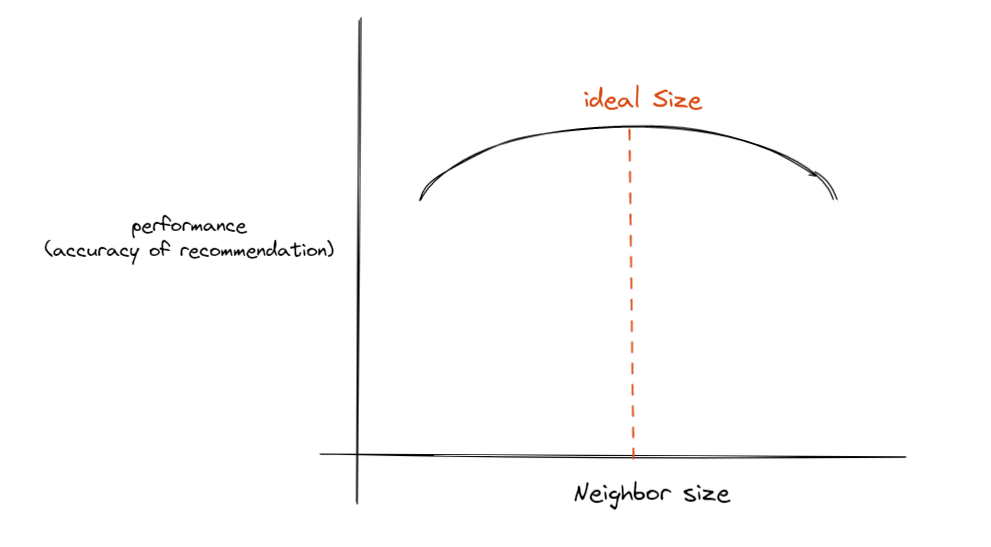

In [13]:
for neighbor_size in [10,20,30,40,50,60]:
  print('Neighbor size = %d : RMSE = %.4f'%(neighbor_size, score_neighbor(CF_knn, neighbor_size)))

Neighbor size = 10 : RMSE = 1.0291
Neighbor size = 20 : RMSE = 1.0154
Neighbor size = 30 : RMSE = 1.0136
Neighbor size = 40 : RMSE = 1.0135
Neighbor size = 50 : RMSE = 1.0139
Neighbor size = 60 : RMSE = 1.0146


## 사용자의 평가경향을 고려한 CF


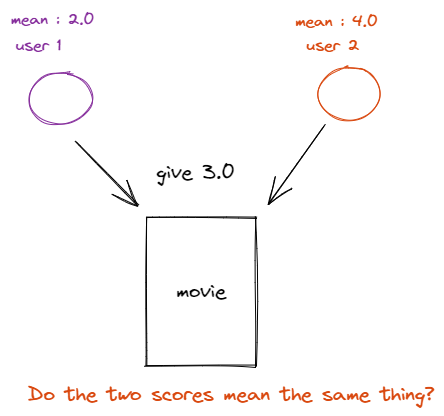

<center>

각 유저의 평점평균(예측치) 계산 <br>

🔽<br>

평점 => 각 유저의 (평점 - 평점 평균 : 평점편차) 값으로 변환<br>

🔽<br>
평점 편차의 예측값 계산<br> 
🔴 평가값 = 평점편차 x 다른 유저의 유사도 🔴<br>


🔽<br>
실제 예측값 = 평점편차 예측값 + 평점 평균(빼준만큼 더해주기_)<br>
</center>


In [31]:
# ratings matrix

rating_mean = ratings_matrix.mean(axis=1) # user_id별로 평균 구하기
rating_bias = (ratings_matrix.T - rating_mean).T # 평점 평균 편차 matrix

# 사용자 평가 경향을 고려한 함수
def CF_knn_bias(user_id, movie_id, neighbor_size=0):
  if movie_id in rating_bias.columns: # 평점평균편차 행렬에 영화 id가 존재하면
    sim_scores = user_similarity[user_id].copy() # 유저 유사도 행 가져오기
    movie_ratings = rating_bias[movie_id].copy() # 해당 영화 평점평균편차 행 가져오기

    # 영화 평점 없는 유저행 삭제
    none_rating_idx = movie_ratings[movie_ratings.isnull()].index 
    movie_ratings = movie_ratings.drop(none_rating_idx)
    sim_scores = sim_scores.drop(none_rating_idx)

    if neighbor_size == 0:# 이웃사이즈 지정 안한 경우
      prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
      prediction = prediction + rating_mean[user_id]

    else:
      if len(sim_scores) > 1: # 유사도 정보가 자기 자신 외 경우가 있다면 (유사집단이 존재 하면)
        neighbor_size = min(neighbor_size, len(sim_scores)) # 유사도 정보 길이와 지정사이즈 중 작은 값을 이웃사이즈로 설정 
        sim_scores = np.array(sim_scores)
        movie_ratings = np.array(movie_ratings)
        user_idx = np.argsort(sim_scores) # 오름차순 정렬
        
        # 이웃 사이즈 만큼 정보 챙기기
        sim_scores = sim_scores[user_idx][-neighbor_size:]
        movie_ratings = movie_ratings[user_idx][-neighbor_size:]
       
        # 예측치
        prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
        prediction = prediction + rating_mean[user_id]

      else:
        prediction = rating_mean[user_id]
  else:
    prediction = rating_mean[user_id]
  
  return prediction

score_neighbor(CF_knn_bias, 30)

0.9448351542877129

## Develop CF Accuracy
1. 신뢰도 가중 추가
- 유사도의 신뢰도는 공통 평가 아이템이 많을 수록 높아짐
- but, 예측값은 민감 -> 공통 평가 아이템 수를 직접적으로 사용하면 성능 저하 발생

✅ 신뢰도에 threshold 방식을 적용<br>
- 공통 아이템 수가 임계치를 넘는 유저만 유사집단으로 정의



In [41]:

rating_binary_1 = np.array(ratings_matrix>0).astype(float) # 평점값이 있다면 1.0(float), 없다면 0.0(float)
rating_binary_2 = rating_binary_1.T

counts = np.dot(rating_binary_1,rating_binary_2)
counts = pd.DataFrame(counts,
                      index=ratings_matrix.index,
                      columns=ratings_matrix.index).fillna(0) # 대각 행렬은 user가 평가한 총 개수, 나머지는 유저별 공통 평가 영화 개수
def CF_knn_bias_sig(user_id, movie_id, neighbor_size=0):
  if movie_id in rating_bias:
    sim_scores = user_similarity[user_id].copy()
    movie_ratings = rating_bias[movie_id].copy()

    no_rating = movie_ratings.isnull()
    common_counts = counts[user_id]
    low_significance = common_counts < SIG_LEVEL
    none_rating_idx = movie_ratings[no_rating | low_significance].index

    movie_ratings = movie_ratings.drop(none_rating_idx)
    sim_scores = sim_scores.drop(none_rating_idx)

    if neighbor_size == 0:
      prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
      prediction = prediction + rating_mean[user_id]

    else:
      if len(sim_scores) > MIN_RATINGS:
        neighbor_size = min(neighbor_size, len(sim_scores))
        sim_scores = np.array(sim_scores)
        movie_ratings = np.array(movie_ratings)
        user_idx = np.argsort(sim_scores)
        sim_scores = sim_scores[user_idx][-neighbor_size:]
        movie_ratings = movie_ratings[user_idx][-neighbor_size:]

        prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
        prediction = prediction + rating_mean[user_id]
      
      else:
        prediction = rating_mean[user_id]

  else:
        prediction = rating_mean[user_id]

  # 넘어가는 값 지정하기
  if prediction <= 1:
    prediction = 1
  elif prediction >= 5 :
    prediction = 5

  return prediction 

SIG_LEVEL = 3
MIN_RATINGS = 3
score_neighbor(CF_knn_bias_sig, 30)

0.9450827645037744

## user-based CF(UBCF) and item-based CF(IBCF)
✅ 유사도를 계산하는 기준에 따라

1. UBCF
- 유저와 비슷한 집단이 공통적으로 좋게 평가한 아이템 추천
- 유저 데이터가 풍부한 경우, 정확한 추천 가능
- 업데이트에 대한 결과 변동 위험성이 존재
<br>
2. IBCF
- 유저 간 평가 패턴을 바탕으로 아이템 간 유사도를 계산, 유저 별로 특정 아이템에 대한 예측 평점 계산 후 추천
- 예측 대상이 평가한 아이템의 평점과 다른 각 아이템간의 유사도를 가중평균하여 예측값으로 사용
- 계산이 빠름
-업데이트에 대한 결과 영향이 적음

In [44]:
ratings_matrix_t = np.transpose(ratings_matrix)

matrix_dummy = ratings_matrix_t.copy().fillna(0)

item_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
item_similarity = pd.DataFrame(item_similarity,
                               index=ratings_matrix_t.index,
                               columns=ratings_matrix_t.index)

def CF_IBCF(user_id, movie_id):
  if movie_id in item_similarity.columns:
    sim_scores = item_similarity[movie_id]
    user_rating = ratings_matrix_t[user_id]
    none_rating_idx = user_rating[user_rating.isnull()].index
    user_rating = user_rating.dropna()
    sim_scores = sim_scores.drop(none_rating_idx)
    mean_rating = np.dot(sim_scores, user_rating) / sim_scores.sum()
  else:
    mean_rating = 3.0

  return mean_rating

score(CF_IBCF)

1.0176843783530516

## 추천 시스템의 성과측정 지표

- cross validation 
- RMSE, MSE, RMAE, MAE : 연속적인 값 = 각 아이템의 예상평점과 실제 평점 차이
- 추천한 아이템과 사용자의 실제 선택을 비교
  - $$accuracy(정확도) = \frac{올바르게\; 추천(예측)된\; 아이템\; 수}{전체\; 아이템\; 수}$$
  - $$precision(정밀도) = \frac{올바르게\; 추천된\; 아이템 \;수}{전체\;추천한\; 아이템의 \;수}$$
  - $$recall(재현율) = \frac{올바르게\; 추천된\; 아이템의\; 수}{사용자가\; 실제\; 선택한\; 전체\; 아이템\; 수}$$

  - 정밀도와 재현율은 **trade-off 관계**

  - $$F1-score(정밀도와\; 재현율의\; 조화평균) = \frac{2*정밀도*재현율}{정밀도 + 재현율}$$
  - $$coverage(범위) = \frac{추천이\; 가능한\; 사용자\; 수(아이템\; 수)}{전체\; 사용자의\; 수(아이템의\; 수)}$$
  - 범위가 넓어지면, 정밀도 감소 : 좁아지면, 정밀도 증가

- TPR, FPR

|    |     |       실제    |          |
|----|:----:|:----------:|:--------:|
|----|----| positive | negative |
|    |positive|TP| FP|
|예측|negative| FN| TN|

- $$TPR(recall) = \frac{TP}{TP+FN}$$

- $$FPR = \frac{FP}{FP+TN}$$

# Reference
- https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=y4769&logNo=220227007641
- http://matrix.skku.ac.kr/math4AI-tools/cosine_similarity/